In [31]:
import torch
import seaborn as sns
import numpy as np

from torch.distributions import Categorical
from IPython.display import Image
from snake_game import SnakeEnv
from snake_agent import SnakeWrapper, SnakePPOModel
from matplotlib import pyplot as plt

MODEL_PATH = 'ppo_snake_5500.pt'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPISODES = 100

## 1. Обучение с подкреплением

Сегодня мы рассмотрим практическое применение обучения с подкреплением (Reinforcement Learning, RL) на примере игры “Змейка”.

RL возникла из потребности решать задачи последовательного принятия решений, где невозможно заранее пронализировать все правильные ответы и получить метки для каждого шага — например, в робототехнике, автономном вождении или управлении логистикой. Благодаря способности обучаться на собственном опыте и оптимизировать стратегию с учётом отложенных наград, RL успешно решает такие задачи, как игра в Go и Dota 2, обучение роботов манипуляциям, а также задачи управления ресурсами и рекомендациями, где традиционные методы не справляются.

Обучение с подкреплением (RL) — это парадигма машинного обучения, в которой агент взаимодействует со средой, совершает действия и получает обратную связь в виде награды. Цель агента — научиться выбирать такие действия, которые максимизируют суммарную награду в долгосрочной перспективе.


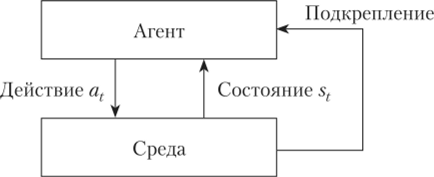

In [32]:
Image(filename="resources/rl.png")

## 2. Марковский процесс принятия решений (MDP)

MDP определяется как квинтет:

$$
(S, A, R, P, \gamma)
$$

* $S$ — набор состояний
* $A$ — набор действий
* $R(s, a)$ — функция награды
* $P(s'|s, a)$ — функция перехода
* $\gamma \in [0,1]$ — дисконтирующий фактор


In [33]:
env = SnakeEnv(grid_size=5, num_food=5)
print(env.reset())

{'snake': [(np.int64(2), np.int64(2))], 'food': {(0, 1), (3, 3), (1, 3), (4, 2), (3, 0)}, 'head': (np.int64(2), np.int64(2))}


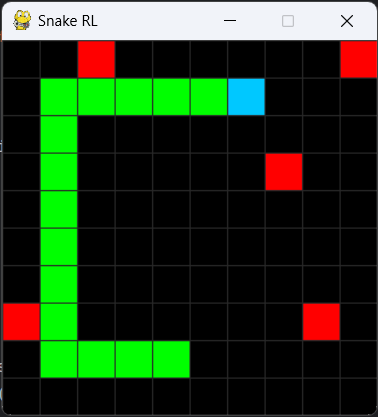

In [38]:
Image(filename="resources/game.png")

## 3. Математика

### Основная идея  
В policy-based методах (например, PPO) мы не учим Q-функцию, а напрямую оптимизируем политику 

$$
\pi_\theta(a \mid s)\in[0,1],
$$

где 

- $s$ — состояние, 
- $a$ — действие,
- $\theta$ — параметры модели.

___

### Policy Gradient  

Цель — максимизировать ожидаемую награду  

$$
J(\theta)=\mathbb{E}_{\pi_\theta}\Bigl[\sum_{t=0}^\infty\gamma^t r_t\Bigr].
$$

Ключевая формула градиента:  

$$
\nabla_\theta J(\theta)
=\mathbb{E}_{\pi_\theta}\bigl[\nabla_\theta\log\pi_\theta(a|s)\ \cdot A(s,a)\bigr].
$$
 
> Log-derivative trick позволяет вынести градиент из ожидания.

___

### Advantage
 
Пусть

$$
A(s,a)=Q(s,a)-V(s),
$$  

где  

- $Q(s,a)=\mathbb{E}\Bigl[\sum_{t=0}^\infty\gamma^t r_t\mid s_0=s,a_0=a\Bigr],\quad$
- $V(s)=\mathbb{E}\Bigl[\sum_{t=0}^\infty\gamma^t r_t\mid s_0=s\Bigr].$


> Для практики часто используют GAE: $\hat A_t=\sum_{l=0}^{T-1}(\gamma\lambda)^l\bigl(r_{t+l}+\gamma V(s_{t+l+1})-V(s_{t+l})\bigr)$, чтобы снизить дисперсию.

___

### Функция потерь  

$$
L^{\rm CLIP}(\theta)
= \mathbb{E}_t\Bigl[
  \min\bigl(r_t(\theta)\,A_t,\;
  \mathrm{clip}(r_t(\theta),1-\epsilon,1+\epsilon)\,A_t\bigr)
\Bigr],
$$
 
где  

- $r_t(\theta) = \frac{\pi_\theta(a_t\mid s_t)}{\pi_{\rm old}(a_t\mid s_t)}$

---

### Алгоритм
 
1. Собрать батч траекторий по текущей политике.  
2. Вычислить $\hat A_t$ и таргеты для $V$.  
3. Провести несколько эпох мини-батчей, оптимизируя $L(\theta)$.  
4. Обновить политику: $\pi_{\rm old}\leftarrow\pi_\theta$.

___

## 4. Применение PPO к задаче

В задаче «Змейка» традиционные алгоритмы оптимизации либо не справляются с долгосрочными зависимостями в цепочке действий, либо требуют жёсткого ручного проектирования правил. Именно здесь и пригодится PPO: он позволяет агенту самостоятельно изучать стратегию через взаимодействие со средой, балансируя между исследованием новых ходов и эксплуатацией уже успешных.

### Состояние (Observation space)

Вход в нейросеть — тензор состояния `[3, grid_size, grid_size]`:

- Канал 0: голова змеи  
- Канал 1: тело  
- Канал 2: еда  

### Пространство действий (Action space)

$$
\mathcal{A} = \{\text{вверх}, \text{вниз}, \text{влево}, \text{вправо}\}
$$

In [35]:
wrapper = SnakeWrapper(env)
x = wrapper.reset().squeeze(0)

print(f'Голова: {x[0]}')
print(f'Тело: {x[1]}')
print(f'Еда: {x[2]}')

Голова: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
Тело: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
Еда: tensor([[0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.]])


### Награды

| Событие                      | Награда                |
|------------------------------|------------------------|
| Смерть (ранняя)              | `-2.0`                 |
| Смерть (позже)               | `-1.0`                 |
| Бездействие > $2 \cdot grid$ | `-1.0`                 |
| Поедание еды                 | $\sqrt(\text{length})$ |
| Любой шаг (пенальти)         | `-0.01`                |

Такой дизайн стимулирует:

- активный поиск еды,
- избегание смерти,
- снижение пустых шагов.

### Архитектура модели

- CNN
- MLP
- Policy-head
- Value-head

### Выход модели

Модель предсказывает два значения:

- **policy logits** — неотнормированные значения для всех действий через $\pi(a|s) = \text{softmax}(\text{logits})$
- **value** — приближённая оценка полезности состояния: $V(s) \approx \mathbb{E}_\pi \left[ \sum_{t=0}^\infty \gamma^t r_t \,\middle|\, s_0 = s \right]$

> Она используется для расчёта $A(s,a) = r + \gamma V(s') - V(s)$



In [36]:
env = SnakeWrapper(SnakeEnv(grid_size=10, num_food=5))

model = SnakePPOModel(num_actions=4).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

episode_rewards = []
timeouts = 0

for _ in range(EPISODES):
    state = env.reset().to(DEVICE)
    done = False
    total_reward = 0
    steps = 0
    no_progress = 0
    prev_reward = 0

    while not done:
        with torch.no_grad():
            logits, _ = model(state)
            dist = Categorical(logits=logits)
            action = dist.sample().item()

        state, reward, done = env.step(action)
        state = state.to(DEVICE)
        total_reward += reward

    episode_rewards.append(total_reward)

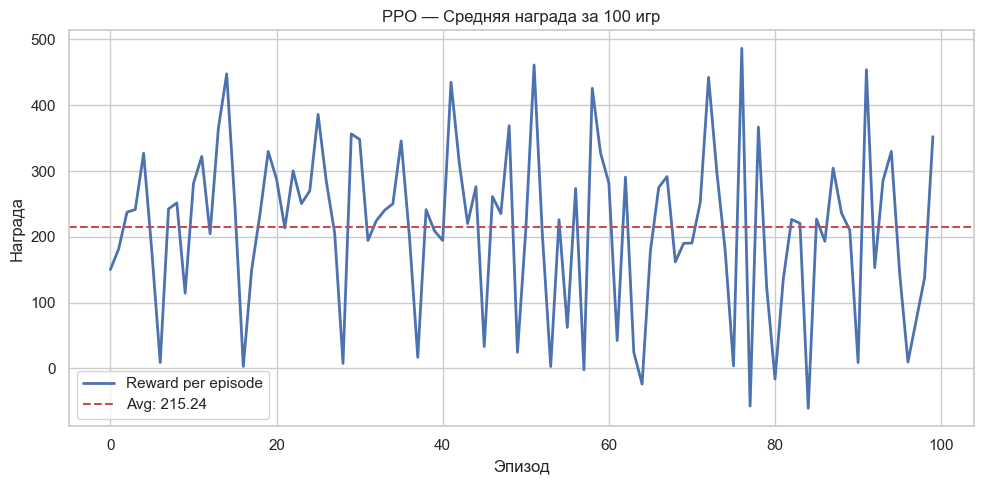

In [37]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 5))
sns.lineplot(data=episode_rewards, label="Reward per episode", linewidth=2)

plt.axhline(np.mean(episode_rewards), color='r', linestyle='--', label=f"Avg: {np.mean(episode_rewards):.2f}")

plt.xlabel("Эпизод")
plt.ylabel("Награда")
plt.title(f"PPO — Средняя награда за {len(episode_rewards)} игр")
plt.legend()
plt.tight_layout()
plt.show()

### Практические трудности

В реальных задачах Reinforcement Learning сталкивается с рядом вызовов:

- **Низкая сэмпл-эффективность**: для достаточного обучения агенту может потребоваться огромное число взаимодействий со средой.  
- **Исследование против эксплуатации**: баланс между поиском новых стратегий и использованием уже найденных решений зачастую требует тщательного тюнинга.  
- **Чувствительность к дизайну наград**: неудачная формулировка функции награды может привести к нежелательным или «читерским» стратегиям.  
- **Sim-to-Real gap**: политика, обученная в симуляции, может плохо переноситься в реальный мир без дополнительных техник адаптации.

> Несмотря на эти сложности, PPO остаётся одним из наиболее стабильных и практичных алгоритмов RL, демонстрируя хорошие результаты и в игровых, и в промышленных приложениях.

## Выводы

Мы обучили агента играть в «Змейку» с помощью алгоритма PPO и получили:

- **Средняя награда ≈ 200** за эпизод, что подтверждает успешное усвоение стратегии.
- **Стабильность и обобщаемость PPO**: алгоритм устойчив к шуму и разным конфигурациям поля.
- **Важность reward shaping**: корректная настройка наград ускоряет конвергенцию и предотвращает «читерские» решения.
- **Индуктивный сдвиг через CNN**: пространственные тензорные представления и свёрточные сети позволяют эффективно выявлять паттерны окружающей среды.
- **Ограничения**: агент плохо справляется с длинными «хвостами» и предвидением самозапирания в узких пространствах.

---

### Перспективы

1. **Дообучение на больших полях**  
   — проверка масштабируемости и устойчивости поведения при увеличении слож­ности среды.  
2. **Модификация архитектуры**  
   — добавить attention-механизмы или внешнюю память (LSTM/Transformer), чтобы улучшить долгосрочное планирование.  
3. **Multi-agent среда**  
   — обучение в конкурентном или кооперативном режиме для изучения взаимодействий между несколькими змеями.  
4. **Автоматизация гиперпараметров**  
   — применение генетических алгоритмов или Bayesian Optimization для оптимизации reward shaping и параметров PPO.  
5. **Sim-to-Real**  
   — адаптация к реальным роботизированным или физическим средам, минимизация разрыва между симуляцией и практикой.
